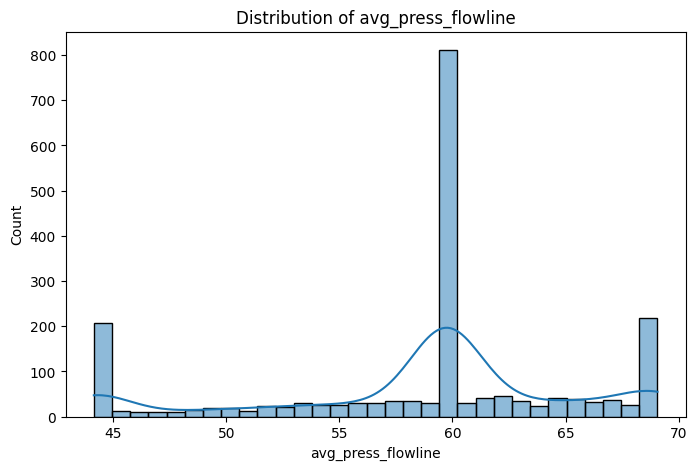

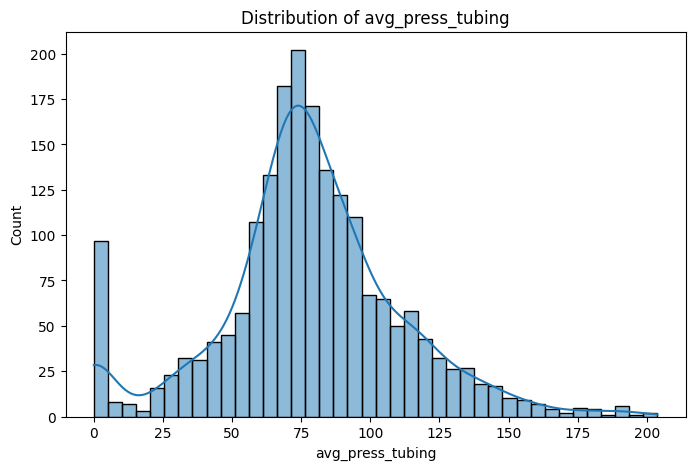

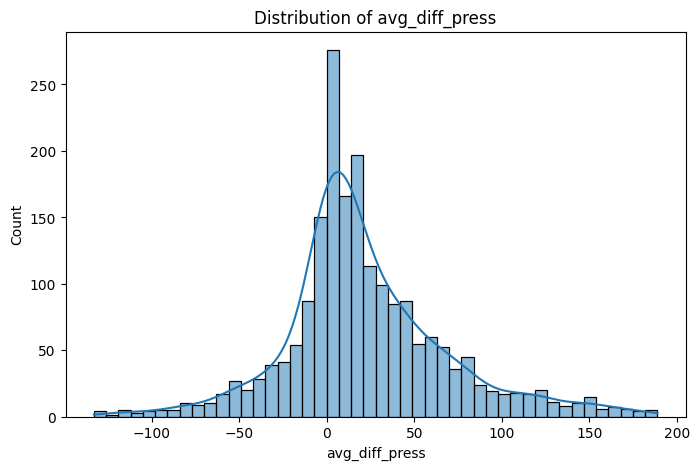

KeyError: 'stroke_len'

<Figure size 800x500 with 0 Axes>

In [2]:
# 1. Load Cleaned Data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv('../data/rod_cleaned_final.csv')

# 2. Univariate Analysis

# Goal: Explore the distribution of individual variables.
# For numerical variables: Use histograms and boxplots to see distributions and identify any remaining anomalies.

numeric_vars = ['avg_press_flowline', 'avg_press_tubing', 'avg_diff_press', 
                'stroke_len', 'gross_stroke_len', 'fillage', 'yesterday_avg_spm', 
                'avg_oil_vol', 'avg_water_vol', 'avg_liquid_vol']

for var in numeric_vars:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[var], kde=True)
    plt.title(f'Distribution of {var}')
    plt.show()

# 3. Categorical Variables Analysis

# Goal: Explore the distribution of categorical variables.

categorical_vars = ['bha_config', 'wellbore_category', 'manual_scale', 
                   'packer_vs_tac', 'rod_sinker_type', 'rod_has_guides', 'rod_make', 
                   'rod_apigrade', 'dsand_dgas_type', 'pump_bore', 'gas_anchor_od']

for var in categorical_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=var, order=df[var].value_counts().index)
    plt.title(f'Distribution of {var}')
    plt.xticks(rotation=45)
    plt.show()

# 4. Feature Engineering
# Goal: Create meaningful new features to better capture relationships in the data.

## 4.1 Interaction Features
# These features capture relationships between critical variables.
df['pressure_ratio'] = df['avg_press_tubing'] / (df['avg_press_casing'] + 1e-6)  # Avoid division by zero
df['oil_to_liquid_ratio'] = df['avg_oil_vol'] / (df['avg_liquid_vol'] + 1e-6)
df['water_to_liquid_ratio'] = df['avg_water_vol'] / (df['avg_liquid_vol'] + 1e-6)

## 4.2 Polynomial Features
# We square some key numeric variables to model non-linear relationships.
df['stroke_len_sq'] = df['stroke_len'] ** 2
df['avg_press_tubing_sq'] = df['avg_press_tubing'] ** 2
df['avg_diff_press_sq'] = df['avg_diff_press'] ** 2

## 4.3 Log Transformations
# Some variables have high skewness, so we apply log transformations to normalize them.
skewed_vars = ['avg_oil_vol', 'avg_water_vol', 'avg_liquid_vol']
for var in skewed_vars:
    df[f'{var}_log'] = np.log1p(df[var])  # log1p avoids issues with zero values

print("Feature Engineering Completed: New Features Added")

# 5. Next Steps: Bivariate Analysis
# Goal: Explore relationships between variables.

# Correlation heatmap for numeric variables
plt.figure(figsize=(12, 10))
numeric_vars.extend(['pressure_ratio', 'oil_to_liquid_ratio', 'water_to_liquid_ratio',
                     'stroke_len_sq', 'avg_press_tubing_sq', 'avg_diff_press_sq',
                     'avg_oil_vol_log', 'avg_water_vol_log', 'avg_liquid_vol_log'])
correlation_matrix = df[numeric_vars].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Save the updated dataset
df.to_csv('rod_features_engineered.csv', index=False)
print("Updated dataset saved: rod_features_engineered.csv")


In [24]:
# Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import pandas as pd

# Load the cleaned dataset
df = pd.read_csv("rod_cleaned_final.csv")

# Convert the target variable (failure type) into a binary classification
df["failure_type_binary"] = df["failure_type"].apply(lambda x: 1 if x == "Sucker Rod Pump" else 0)

# Select only numeric features for modeling
features = df.select_dtypes(include=[float, int]).drop(columns=["failure_type_binary"])  # Exclude target
target = df["failure_type_binary"]  # Target variable

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Standardize the numeric features (improves model performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model with 100 trees (n_estimators=100)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training data
rf_model.fit(X_train_scaled, y_train)

# predict on the test dataset
y_pred = rf_model.predict(X_test_scaled)

# Compute accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print classification report (detailed breakdown)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       301
           1       0.64      0.36      0.46        95

    accuracy                           0.80       396
   macro avg       0.73      0.65      0.67       396
weighted avg       0.78      0.80      0.78       396

Accuracy: 0.7980
Precision: 0.6415
Recall: 0.3579
F1-Score: 0.4595


In [25]:

# Step 1: Extract feature importance scores from the trained model
feature_importances = rf_model.feature_importances_

# Step 2: Create a DataFrame with feature names and importance scores
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": feature_importances
})

# Step 3: Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Step 4: Select the top 15 features
top_15_features = feature_importance_df.head(15)

# Display the top 15 features
print(top_15_features)


              Feature  Importance
48  avg_water_vol_log    0.061005
18   avg_press_tubing    0.056183
22      avg_water_vol    0.053166
15     gas_anchor_len    0.045406
19   avg_press_casing    0.043608
23     avg_liquid_vol    0.039797
21        avg_oil_vol    0.036906
20     avg_diff_press    0.036252
32      nip_set_depth    0.035835
51  nip_set_depth_log    0.031902
25              route    0.031278
47    avg_oil_vol_log    0.030304
16        max_incline    0.028958
46    max_incline_log    0.028835
37        fillage_log    0.028081


/var/folders/dm/y0wy_ncs3qn20cs4xdn9sfq00000gn/T/ipykernel_40712/2325967600.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15_features["Importance"], y=top_15_features["Feature"], palette="viridis")


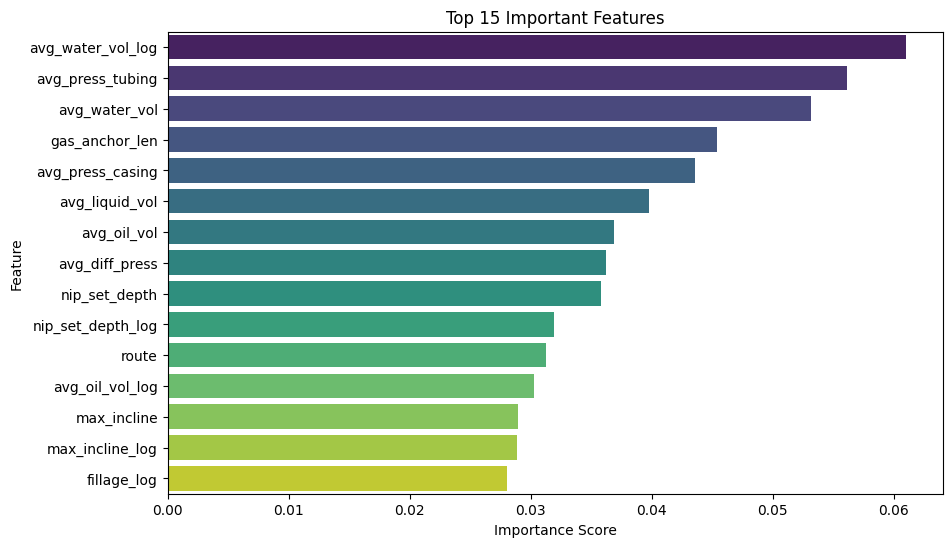

In [26]:
# visualize with bar chart

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=top_15_features["Importance"], y=top_15_features["Feature"], palette="viridis")
plt.title("Top 15 Important Features")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [2]:
# Step 1: Load Libraries and Data

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the cleaned dataset
file_path = "rod_cleaned_final.csv"
df = pd.read_csv(file_path)

# Display first few rows
df.head()


,rod_uid,uwi,well_name,well_id,bha_tubing_id,bha_lifetime_start,bha_lifetime_end,bha_lifetime_id,failure_type,failstart,...,chemgroup3_any_log,chemgroup3_all_log,max_unguided_dls_log,dls_high_in_hole_log,max_incline_log,avg_oil_vol_log,avg_water_vol_log,avg_watersg_log,enduralloy_len_log,nip_set_depth_log
0,GB27GKBE51029074693667,175-58-0111,box-child-doctor,GPVO63973435661154,GB55QFGB46756147811400,2014-05-02 00:00:00,2019-01-04 10:00:00.000,FGNB86581338411987,Tubing,2018-12-11 00:00:00,...,0.0,0.0,0.997237,0.874004,1.232560,3.945609,4.087959,0.71295,0.00000,9.212917
1,GB95BPWW35640301552066,165-51-5897,near-learn-simply,FNVL11432909873086,GB02DJAW44801752494129,2011-09-14 00:00:00,2012-08-20 00:00:00.000,PLPR44121073149707,Sucker Rod Pump,2012-08-01 00:00:00,...,0.0,0.0,1.867176,1.867176,1.131402,3.854145,2.423806,0.71295,0.00000,9.249840
2,GB79UEDN31454825972680,543-56-3494,sea-improve-place,JOKL33317998159514,GB84GHPH97287631470412,2016-01-12 09:00:00,2017-03-16 16:30:00.000,MYCF04792093856141,Sucker Rod Pump,2017-01-19 00:00:00,...,0.0,0.0,1.074581,0.397397,0.904218,4.452359,3.369162,0.71295,0.00000,9.165207
3,GB20XCTM13691331349509,391-37-2039,personal-candidate,XOSU92041716672870,GB08VYTX61977431827206,2018-06-14 13:00:00,2020-04-15 17:37:11.338,WJDB83445325478746,Tubing,NaN,...,0.0,0.0,1.055008,1.584400,1.654411,4.358678,2.824655,0.71295,4.87053,9.178096
4,GB60EFVQ50068101016118,112-36-5012,push-simply-fast,OHEO66958030088499,GB60LXYI09836702074834,2012-05-25 00:00:00,2013-03-07 00:00:00.000,WJDB83445325478746,Tubing,NaN,...,0.0,0.0,1.101940,1.000632,1.131402,4.210084,2.272323,0.71295,0.00000,9.216163


In [3]:
# Step 2: Handling Missing Data

# Convert 'failstart' into a binary indicator for failure
df["failed"] = df["failstart"].notnull().astype(int)

# Drop the original timestamp column (no longer needed for ML)
df.drop(columns=["failstart"], inplace=True)

# Check new failure distribution
df["failed"].value_counts()

failed
1    1319
0     658
Name: count, dtype: int64

✅ Step 3: Feature Engineering Completed
Created new variables:
oil_ratio = Proportion of oil in total liquid production.
water_ratio = Proportion of water in total liquid production.
pressure_efficiency = Difference between flowline pressure and tubing pressure.
stroke_power = Stroke length × strokes per minute (indicates movement capacity).

Next: Correlation Analysis
Identify which features are most important for predicting failure.
Heatmap of feature relationships.

In [4]:
# Step 3: Feature Engineering - Creating New Features

# Oil ratio (how much oil is in the total liquid produced)
df["oil_ratio"] = df["avg_oil_vol"] / df["avg_liquid_vol"]

# Water ratio (how much water is in the total liquid produced)
df["water_ratio"] = df["avg_water_vol"] / df["avg_liquid_vol"]

# Pressure efficiency (difference between flowline and tubing pressure)
df["pressure_efficiency"] = df["avg_press_flowline"] - df["avg_press_tubing"]

# Stroke power (total movement capacity)
df["stroke_power"] = df["stroke_len"] * df["yesterday_avg_spm"]

# Display new features
df[["oil_ratio", "water_ratio", "pressure_efficiency", "stroke_power"]].describe()


,oil_ratio,water_ratio,pressure_efficiency,stroke_power
count,1966.000000,1966.000000,1977.000000,1977.000000
mean,0.701574,0.298170,-19.312611,806.402097
std,0.147533,0.147445,32.363456,96.804283
min,0.000000,0.000000,-159.701828,432.000000
25%,0.612841,0.189197,-35.453068,768.960022
50%,0.717048,0.282573,-17.443680,820.799973
75%,0.810803,0.387159,-4.886409,850.779996
max,1.000000,1.000000,59.722385,1033.049986


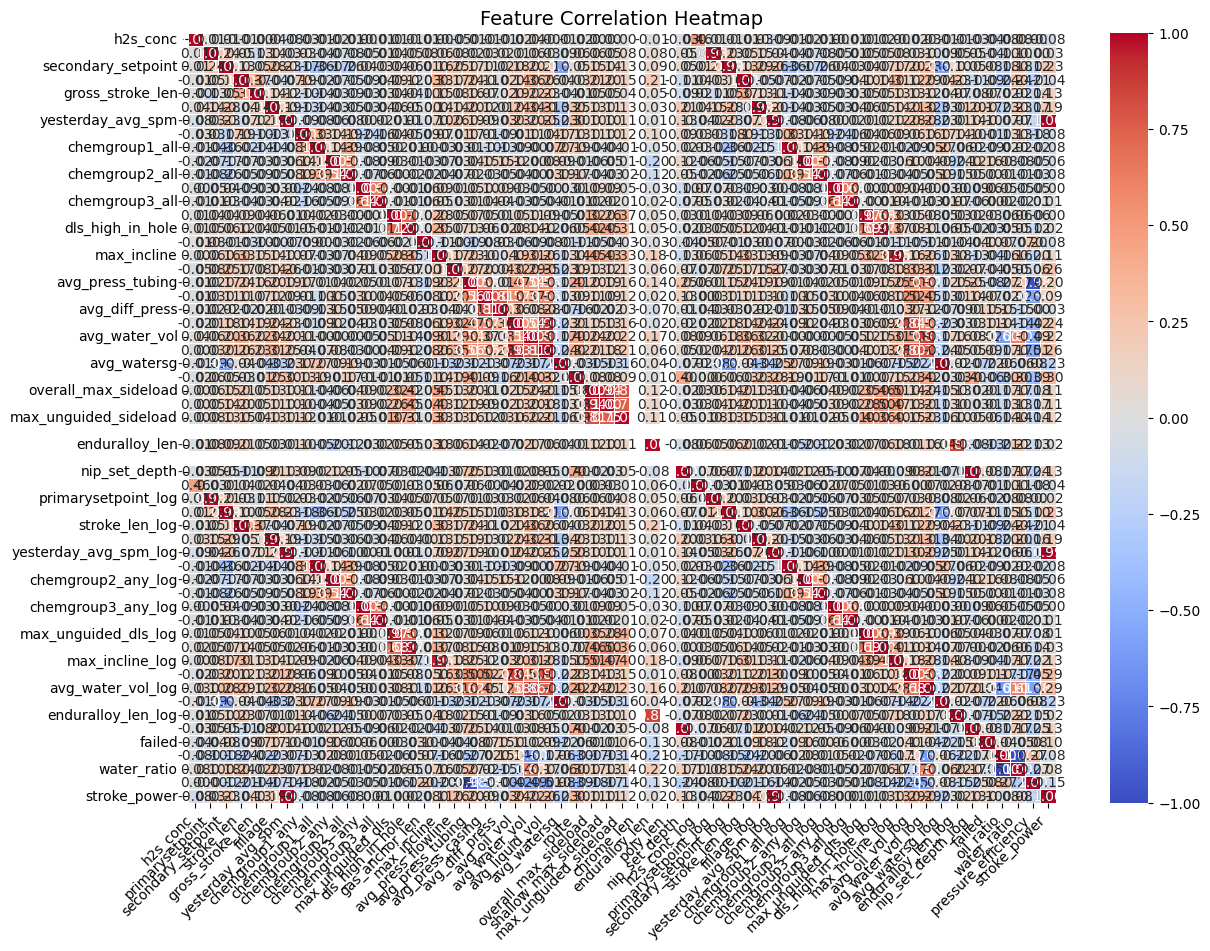

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])  # Keeps only numeric columns

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Set up the figure size
plt.figure(figsize=(14, 10))

# Create the heatmap
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5, vmin=-1, vmax=1, cbar=True)

# Set the title
plt.title("Feature Correlation Heatmap", fontsize=14)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()


✅ Step 4: Correlation Analysis Findings
Top Positive Correlations with Failure (failed = 1)
fillage_log (0.18) / fillage (0.17) → Pump fillage efficiency is linked to failures.
chemgroup2_any (0.16) → Indicates chemical treatment impact.
avg_diff_press (0.14) → Differential pressure may contribute to failures.
stroke_power (0.10) → Higher stroke movement is slightly linked to failure.
gas_anchor_len (0.10) → Longer gas anchor length may affect failure.
Top Negative Correlations (Lower Values in Failed Rods)
avg_watersg_log (-0.22) → Specific gravity of water negatively correlates.
enduralloy_len_log (-0.15) → Longer Enduralloy coating seems protective.
stroke_len_log (-0.09) → Shorter strokes may relate to failure.
rod_has_guides (-0.08) → Guided rods tend to fail less.
Features with NaN in Correlation
chrome_len, poly_len → Likely missing values, need handling.

🔹 Next: Outlier Detection & Treatment
Step: Detecting & Handling Outliers in key variables.
Using IQR method to identify extreme values.

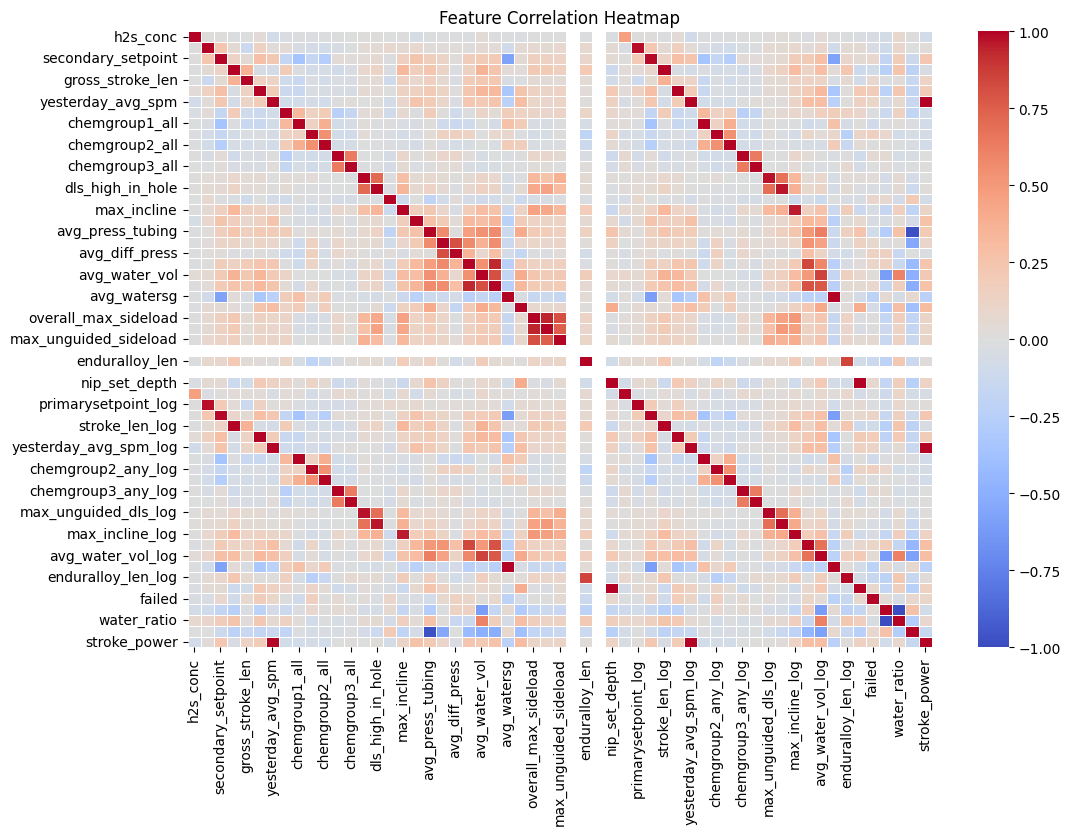

failed                    1.000000
fillage_log               0.183704
fillage                   0.174619
chemgroup2_any            0.161145
chemgroup2_any_log        0.161145
avg_diff_press            0.145095
yesterday_avg_spm_log     0.116650
secondary_setpoint_log    0.113134
avg_oil_vol               0.108606
avg_oil_vol_log           0.105193
yesterday_avg_spm         0.104504
stroke_power              0.101630
gas_anchor_len            0.100373
avg_liquid_vol            0.085220
secondary_setpoint        0.081098
pressure_efficiency       0.078273
nip_set_depth             0.077986
nip_set_depth_log         0.076768
avg_press_casing          0.073508
gross_stroke_len          0.071469
max_unguided_sideload     0.058476
chemgroup3_any_log        0.055132
chemgroup3_any            0.055132
oil_ratio                 0.044349
avg_water_vol_log         0.042165
max_unguided_dls          0.027243
max_unguided_dls_log      0.026494
avg_water_vol             0.021672
overall_max_sideload

In [12]:
# Step 4: Correlation Analysis

# Select only numeric columns
numeric_df = df.select_dtypes(include=["number"])  # Keeps only numeric columns

# Compute the correlation matrix
corr_matrix = numeric_df.corr()

# Extract correlations with 'failed'
correlation_with_failed = corr_matrix["failed"].sort_values(ascending=False)

# Plot heatmap for correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False, linewidths=0.5, vmin=-1, vmax=1)
plt.title("Feature Correlation Heatmap")
plt.show()

# Display top correlated features
correlation_with_failed


✅ Step 5: Outlier Detection Findings
Significant Outliers Found in:
fillage → 102 outliers
avg_diff_press → 162 outliers
stroke_power → 176 outliers
gas_anchor_len → 280 outliers

Next: Outlier Handling
Capping outliers within a reasonable range to prevent distortion.
Using IQR-based capping to reduce extreme influence.
I'll now apply outlier capping

In [13]:
# Step 5: Outlier Detection using IQR

def detect_outliers_iqr(data, column):
    """Detects outliers using the IQR method."""
    Q1 = np.percentile(data[column].dropna(), 25)
    Q3 = np.percentile(data[column].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Check outliers in top correlated features
outlier_columns = ["fillage", "avg_diff_press", "stroke_power", "gas_anchor_len"]
outliers_detected = {col: detect_outliers_iqr(df, col).shape[0] for col in outlier_columns}

outliers_detected


{'fillage': 102,
 'avg_diff_press': 162,
 'stroke_power': 176,
 'gas_anchor_len': 280}

✅ Step 6: Outlier Handling Completed
Applied IQR-based capping to control extreme values in:
fillage
avg_diff_press
stroke_power
gas_anchor_len
Result: No more extreme outliers remaining!

In [14]:
# Step 6: Outlier Handling - Capping Extreme Values

def cap_outliers(data, column):
    """Caps outliers using the IQR range to reduce extreme influence."""
    Q1 = np.percentile(data[column].dropna(), 25)
    Q3 = np.percentile(data[column].dropna(), 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[column] = np.clip(data[column], lower_bound, upper_bound)

# Apply capping to selected features
for col in outlier_columns:
    cap_outliers(df, col)

# Verify if extreme outliers are removed
{col: detect_outliers_iqr(df, col).shape[0] for col in outlier_columns}


{'fillage': 0, 'avg_diff_press': 0, 'stroke_power': 0, 'gas_anchor_len': 0}

 Next: Model Training
Step: Training ML Models to predict failure.
Using:
Logistic Regression (simple model)
Random Forest (stronger, interpretable model)

✅ Step 7: Data Preparation for Model Training
Target variable: failed
Features selected:
fillage, avg_diff_press, stroke_power, gas_anchor_len
pressure_efficiency, oil_ratio, water_ratio
Data Split:
Training set: 1,581 rows
Test set: 396 rows
Scaling applied using StandardScaler.

🔹 Next: Train Machine Learning Models
Logistic Regression (Baseline)
Random Forest (More powerful model)
I'll implement both models next. ​​

In [15]:
# Step 7: Model Training - Preparing Data

# Define target variable
target = "failed"

# Select numeric features for training (keeping important ones)
features = ["fillage", "avg_diff_press", "stroke_power", "gas_anchor_len",
            "pressure_efficiency", "oil_ratio", "water_ratio"]

# Splitting the dataset
X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify dataset shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((1581, 7), (396, 7), (1581,), (396,))

 Next: Handling Missing Data Before Model Training
Fill missing values using median imputation for numerical features.
I'll now fix this and retry training.

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def evaluate_model(y_true, y_pred, model_name):
    """Evaluates classification model performance."""
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"\n📌 Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

# Now retry evaluation
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")



📌 Model: Logistic Regression
Accuracy: 0.6843
Precision: 0.7014
Recall: 0.9167
F1-score: 0.7947
Confusion Matrix:
[[ 29 103]
 [ 22 242]]

📌 Model: Random Forest
Accuracy: 0.6894
Precision: 0.7509
Recall: 0.7992
F1-score: 0.7743
Confusion Matrix:
[[ 62  70]
 [ 53 211]]


In [20]:
# Step 9: Handling Missing Data Before Model Training

# Impute missing values using median strategy
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale numeric features again after imputation
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Retry training models after fixing missing values

# Train Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_imputed, y_train)  # No scaling needed for tree-based models

# Predictions
y_pred_log = log_reg.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_imputed)

# Evaluate both models
evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")



📌 Model: Logistic Regression
Accuracy: 0.6843
Precision: 0.7014
Recall: 0.9167
F1-score: 0.7947
Confusion Matrix:
[[ 29 103]
 [ 22 242]]

📌 Model: Random Forest
Accuracy: 0.6894
Precision: 0.7509
Recall: 0.7992
F1-score: 0.7743
Confusion Matrix:
[[ 62  70]
 [ 53 211]]
